# 1. Import Dataset 

In [0]:
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing


SEQ_LEN = 60  
FUTURE_PERIOD_PREDICT = 3  
RATIO_TO_PREDICT = "LTC-USD"
main_df = pd.DataFrame() 

#classify for classifying buys and don't buys 
#if future price is high den by else don't buy
def classify(curnt, future):
    if float(future) > float(curnt):  
        return 1
    else:  
        return 0


# 2. Data Pre-processing

In [15]:
def preprocessData(df):
    df = df.drop("future", 1)  

    for col in df.columns:  
        if col != "target":  
            df[col] = df[col].pct_change()  
            df.dropna(inplace=True)  
            df[col] = preprocessing.scale(df[col].values)  

    df.dropna(inplace=True)  


    sequential_data = []  # list of sequence data
    prev_days = deque(maxlen=SEQ_LEN) # actucal list  of sequence data made of dequesue 

    for i in df.values:  
        prev_days.append([n for n in i[:-1]])  
        if len(prev_days) == SEQ_LEN:  
            sequential_data.append([np.array(prev_days), i[-1]])   

    buys = []  
    sells = []  
    
    #if the target is 1 then it is a buy else it is sells
    
    for seq, target in sequential_data:  
        if target == 0:  
            sells.append([seq, target])  
        elif target == 1:  
            buys.append([seq, target])  

    #shuffle for good measures
    random.shuffle(buys)  
    random.shuffle(sells)  

    lower = min(len(buys), len(sells))  

    buys = buys[:lower]  
    sells = sells[:lower]  

    sequential_data = buys+sells  
    random.shuffle(sequential_data)  
    
    sequences = []
    targets = []

    for seq, target in sequential_data:  
        sequences.append(seq)  
        targets.append(target)  

    return np.array(sequences), targets  


main_df = pd.DataFrame() 

datas = ["BCH-USD", "ETH-USD", "BTC-USD", "LTC-USD"]  
for data in datas:  
    print(data)
    dataset = '{}.csv'.format(data)  
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  

    df.rename(columns={"close": "{}_close".format(data), "volume": "{}_volume".format(data)}, inplace=True)

    df.set_index("time", inplace=True)  
    df = df[["{}_close".format(data), "{}_volume".format(data)]] 

    if len(main_df)==0: 
        main_df = df  
    else:  
        main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  
main_df.dropna(inplace=True)

main_df['future'] = main_df['{}_close'.format(RATIO_TO_PREDICT)].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df['{}_close'.format(RATIO_TO_PREDICT)], main_df['future']))

main_df.dropna(inplace=True)

#Taking last 10% only for good measures

times = sorted(main_df.index.values)
last_pct = sorted(main_df.index.values)[-int(0.10*len(times))]

validation_main_df = main_df[(main_df.index >= last_pct)]
main_df = main_df[(main_df.index < last_pct)]

print(main_df.head())


BCH-USD
ETH-USD
BTC-USD
LTC-USD
            BCH-USD_close  BCH-USD_volume  ETH-USD_close  ETH-USD_volume  \
time                                                                       
1528968720     870.859985       26.856577      486.01001       26.019083   
1528968780     870.099976        1.124300      486.00000        8.449400   
1528968840     870.789978        1.749862      485.75000       26.994646   
1528968900     870.000000        1.680500      486.00000       77.355759   
1528968960     869.989990        1.669014      486.00000        7.503300   

            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.38999

In [0]:

train_x, train_y = preprocessData(main_df)
validation_x, validation_y = preprocessData(validation_main_df)



In [0]:
import time

EPOCHS = 10  
BATCH_SIZE = 64  


# 3. Benchmark Model(Model-1)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization

model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train 
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
)
# Score 
score = model.evaluate(validation_x, validation_y, verbose=0)
print(' loss:', score[0])
print(' accuracy:', score[1])




Train on 71006 samples, validate on 7810 samples
Epoch 1/10
71006/71006 [==============================] - 47s 665us/step - loss: 0.7154 - acc: 0.5256 - val_loss: 0.6867 - val_acc: 0.5387
Epoch 2/10
71006/71006 [==============================] - 45s 639us/step - loss: 0.6879 - acc: 0.5436 - val_loss: 0.6826 - val_acc: 0.5545
Epoch 3/10
71006/71006 [==============================] - 45s 635us/step - loss: 0.6839 - acc: 0.5563 - val_loss: 0.6801 - val_acc: 0.5570
Epoch 4/10
71006/71006 [==============================] - 45s 636us/step - loss: 0.6822 - acc: 0.5618 - val_loss: 0.6822 - val_acc: 0.5644
Epoch 5/10
71006/71006 [==============================] - 45s 635us/step - loss: 0.6802 - acc: 0.5651 - val_loss: 0.6797 - val_acc: 0.5597
Epoch 6/10
71006/71006 [==============================] - 45s 629us/step - loss: 0.6788 - acc: 0.5687 - val_loss: 0.6785 - val_acc: 0.5604
Epoch 7/10
71006/71006 [==============================] - 44s 619us/step - loss: 0.6772 - acc: 0.5729 - val_loss: 0.6

In [19]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


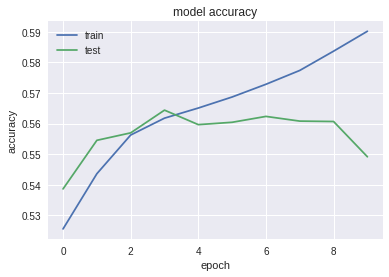

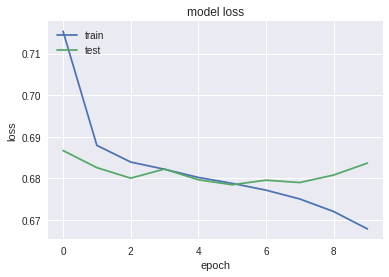

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

#  history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#  history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model-2

Train on 71006 samples, validate on 7810 samples
Epoch 1/10
71006/71006 [==============================] - 67s 940us/step - loss: 0.7081 - acc: 0.5217 - val_loss: 0.6875 - val_acc: 0.5489
Epoch 2/10
71006/71006 [==============================] - 64s 905us/step - loss: 0.6889 - acc: 0.5383 - val_loss: 0.6824 - val_acc: 0.5572
Epoch 3/10
71006/71006 [==============================] - 64s 907us/step - loss: 0.6849 - acc: 0.5527 - val_loss: 0.6785 - val_acc: 0.5624
Epoch 4/10
71006/71006 [==============================] - 64s 907us/step - loss: 0.6824 - acc: 0.5599 - val_loss: 0.6777 - val_acc: 0.5697
Epoch 5/10
71006/71006 [==============================] - 64s 903us/step - loss: 0.6803 - acc: 0.5668 - val_loss: 0.6780 - val_acc: 0.5615
Epoch 6/10
71006/71006 [==============================] - 64s 904us/step - loss: 0.6785 - acc: 0.5711 - val_loss: 0.6787 - val_acc: 0.5609
Epoch 7/10
71006/71006 [==============================] - 64s 897us/step - loss: 0.6756 - acc: 0.5754 - val_loss: 0.6

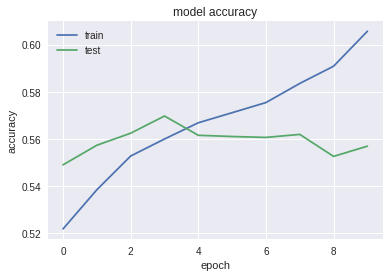

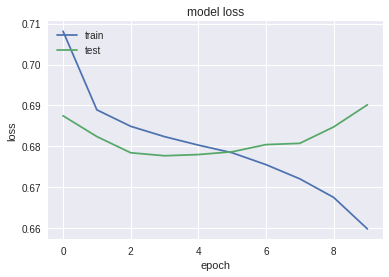

In [21]:
model = Sequential()
model.add(CuDNNLSTM(64, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  

model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train 
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
)
# Score 
score = model.evaluate(validation_x, validation_y, verbose=0)
print(' loss:', score[0])
print(' accuracy:', score[1])

#  history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#  history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model -3


Train on 71006 samples, validate on 7810 samples
Epoch 1/10
71006/71006 [==============================] - 80s 1ms/step - loss: 0.7120 - acc: 0.5016 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/10
71006/71006 [==============================] - 72s 1ms/step - loss: 0.6941 - acc: 0.5035 - val_loss: 0.6920 - val_acc: 0.5446
Epoch 3/10
71006/71006 [==============================] - 72s 1ms/step - loss: 0.6906 - acc: 0.5264 - val_loss: 0.6912 - val_acc: 0.5321
Epoch 4/10
71006/71006 [==============================] - 72s 1ms/step - loss: 0.6878 - acc: 0.5402 - val_loss: 0.6844 - val_acc: 0.5504
Epoch 5/10
71006/71006 [==============================] - 74s 1ms/step - loss: 0.6867 - acc: 0.5442 - val_loss: 0.6880 - val_acc: 0.5254
Epoch 6/10
71006/71006 [==============================] - 72s 1ms/step - loss: 0.6856 - acc: 0.5495 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 7/10
71006/71006 [==============================] - 71s 1ms/step - loss: 0.6921 - acc: 0.5196 - val_loss: 0.6878 - val_acc:

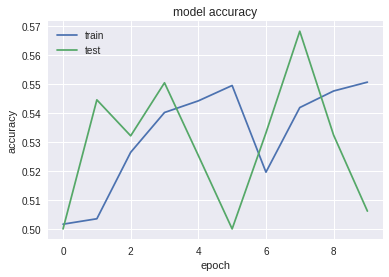

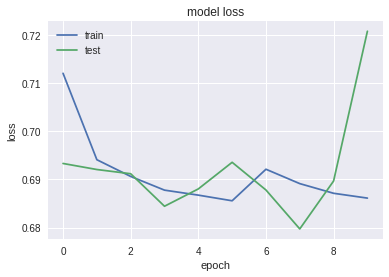

In [22]:

model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train 
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
)
# Score 
score = model.evaluate(validation_x, validation_y, verbose=0)
print(' loss:', score[0])
print(' accuracy:', score[1])

#  history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#  history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Final Model(Model - 4)

Train on 71006 samples, validate on 7810 samples
Epoch 1/10
71006/71006 [==============================] - 55s 775us/step - loss: 0.7687 - acc: 0.5025 - val_loss: 0.6929 - val_acc: 0.5042
Epoch 2/10
71006/71006 [==============================] - 51s 725us/step - loss: 0.6941 - acc: 0.5025 - val_loss: 0.6930 - val_acc: 0.5174
Epoch 3/10
71006/71006 [==============================] - 52s 725us/step - loss: 0.6932 - acc: 0.5052 - val_loss: 0.6929 - val_acc: 0.5022
Epoch 4/10
71006/71006 [==============================] - 52s 726us/step - loss: 0.6931 - acc: 0.5066 - val_loss: 0.6922 - val_acc: 0.5188
Epoch 5/10
71006/71006 [==============================] - 52s 727us/step - loss: 0.6927 - acc: 0.5067 - val_loss: 0.6919 - val_acc: 0.5145
Epoch 6/10
71006/71006 [==============================] - 54s 755us/step - loss: 0.6921 - acc: 0.5151 - val_loss: 0.6899 - val_acc: 0.5475
Epoch 7/10
71006/71006 [==============================] - 52s 726us/step - loss: 0.6916 - acc: 0.5184 - val_loss: 0.6

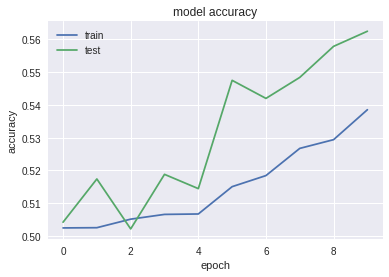

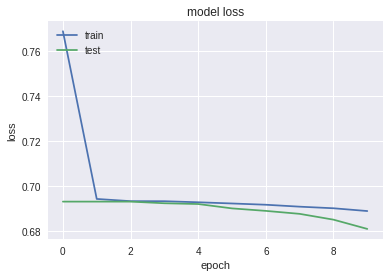

In [31]:
from tensorflow.keras.layers import  Activation


model = Sequential()
model.add(CuDNNLSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())  

model.add(CuDNNLSTM(32,return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(CuDNNLSTM(32))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train 
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
)
# Score 
score = model.evaluate(validation_x, validation_y, verbose=0)
print(' loss:', score[0])
print(' accuracy:', score[1])

#  history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#  history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()